In [1]:
## Notebook env: random (R kernel)
## Notebook original env: mirtud_env (R kernel) -- switched due need of twosamples package for Anderson-Darling test

In [1]:
library(Seurat)
library(tidyr)
library(dplyr)
library(ggplot2)
library(ggrepel)
library(ggpubr)
library(twosamples)

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.3.2 but the current version is
4.3.3; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
adata.R = readRDS('/home/ssobti/projects/mir_tud/101423_filtered_data/tRF_normalized_integrated_seurat.rds')

In [3]:
adata.R <- CellCycleScoring(object = adata.R, g2m.features = cc.genes$g2m.genes, s.features = cc.genes$s.genes)

Warning message:
“The following features are not present in the object: MCM5, PCNA, TYMS, MCM2, MCM4, RRM1, UNG, GINS2, MCM6, CDCA7, PRIM1, UHRF1, MLF1IP, HELLS, RFC2, RPA2, NASP, GMNN, WDR76, SLBP, UBR7, POLD3, MSH2, RAD51, CDC45, TIPIN, DSCC1, BLM, CASP8AP2, USP1, CHAF1B, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: CKS1B, TMPO, FAM64A, ANP32E, HN1, RANGAP1, ECT2, LBR, CTCF, CBX5, not searching for symbol synonyms”


In [4]:
## throw out guides with cells < 30
guides_above_cutoff = adata.R@meta.data$guide %>% table %>% as.data.frame %>% filter(Freq > 30) %>% pull('.') %>% as.character()
adata.R <- subset(adata.R, subset = guide %in% guides_above_cutoff)

In [8]:
dim(s_scores_df)

[1] 141   3

In [6]:
## select out 30 cells per guide for the analysis
## select 10 seeds for 10 samplings of 30 cells per guide -- also the random guides will contain 10 different random combinations of cells
seeds = c(123, 456, 789, 101112, 131415, 161718, 192021, 222324, 252627, 282930)

s_scores_df_list = list()
g2m_scores_df_list = list()

for (i in 1:length(seeds)){
    set.seed(seeds[i])
    adata.R@meta.data -> meta
    meta %>% group_by(guide) %>% sample_n(30) %>% ungroup -> meta  ## select 30 cells per guide

    ## get the median scores for each guide
    s_scores_df = data.frame(score = meta$S.Score, guide = meta$guide, type = ifelse(startsWith(meta$guide, 'TuD_NC'), 'control', 'guide'))
    s_scores_df %>% group_by(guide) %>% summarise(score = median(score), type = unique(type)) -> s_scores_df
    g2m_scores_df = data.frame(score = meta$G2M.Score, guide = meta$guide, type = ifelse(startsWith(meta$guide, 'TuD_NC'), 'control', 'guide'))
    g2m_scores_df %>% group_by(guide) %>% summarise(score = median(score), type = unique(type)) -> g2m_scores_df

    ## add bkg distribution of guide 
    ## this is just median scores for each guide where the cells are randomly assigned to guides
    ## Note: the number of cells assigned to each guide is kept the same
    
    meta$random_guide = sample(meta$guide, replace = FALSE)
    meta$random_guide = paste0('random_', meta$random_guide)
    s_scores_df_random = data.frame(score = meta$S.Score, guide = meta$random_guide, type = ifelse(startsWith(meta$random_guide, 'TuD_NC'), 'control', 'guide'))
    s_scores_df_random %>% group_by(guide) %>% summarise(score = median(score), type = unique(type)) -> s_scores_df_random
    g2m_scores_df_random = data.frame(score = meta$G2M.Score, guide = meta$random_guide, type = ifelse(startsWith(meta$random_guide, 'TuD_NC'), 'control', 'guide'))
    g2m_scores_df_random %>% group_by(guide) %>% summarise(score = median(score), type = unique(type)) -> g2m_scores_df_random

    s_scores_df_list[[i]] = rbind(s_scores_df, s_scores_df_random)
    g2m_scores_df_list[[i]] = rbind(g2m_scores_df, g2m_scores_df_random)

}

In [6]:
options(repr.plot.width = 17, repr.plot.height = 8)
s_phase_plots = list()
g2m_phase_plots = list()
plots = list()
for (i in 1:length(seeds)){
    s_phase_plots[[i]] = ggplot(s_scores_df_list[[i]], aes(x=type, y=score)) + 
    geom_violin(trim=FALSE) + geom_point() + geom_text_repel(aes(label=guide)) + ggtitle('Median S Phase scores') + theme_bw() + theme(plot.title = element_text(hjust = 0.5))

    g2m_phase_plots[[i]] = ggplot(g2m_scores_df_list[[i]], aes(x=type, y=score)) + 
    geom_violin(trim=FALSE) + geom_point() + geom_text_repel(aes(label=guide)) + ggtitle('Median G2M Phase scores') + theme_bw() + theme(plot.title = element_text(hjust = 0.5))

    plots[[i]] = ggarrange(s_phase_plots[[i]], g2m_phase_plots[[i]], ncol = 2)
}


In [7]:
### quantify frequency of guides in top 10% or bottom 10% across 10 random starts
## if a guide appears in the top 10% of scores across 10 random starts, it is a good guide
## consider the appearance of random guides as a signal floor

names(s_scores_df_list) = paste0('seed_', seeds)
s_scores_df_list_combined = bind_rows(s_scores_df_list, .id = 'random_start')
names(g2m_scores_df_list) = paste0('seed_', seeds)
g2m_scores_df_list_combined = bind_rows(g2m_scores_df_list, .id = 'random_start')

s_scores_df_list_combined %>% group_by(random_start) %>% filter(score > quantile(score, 0.9)) %>% pull(guide) %>% as.character() -> s_scores_top_guides
s_scores_df_list_combined %>% group_by(random_start) %>% filter(score < quantile(score, 0.1)) %>% pull(guide) %>% as.character() -> s_scores_bottom_guides
g2m_scores_df_list_combined %>% group_by(random_start) %>% filter(score > quantile(score, 0.9)) %>% pull(guide) %>% as.character() -> g2m_scores_top_guides
g2m_scores_df_list_combined %>% group_by(random_start) %>% filter(score < quantile(score, 0.1)) %>% pull(guide) %>% as.character() -> g2m_scores_bottom_guides

s_scores_top_guides = table(s_scores_top_guides) %>% as.data.frame %>% arrange(-Freq) %>% head(10)
s_scores_bottom_guides = table(s_scores_bottom_guides) %>% as.data.frame %>% arrange(-Freq) %>% head(10)
g2m_scores_top_guides = table(g2m_scores_top_guides) %>% as.data.frame %>% arrange(-Freq) %>% head(10)
g2m_scores_bottom_guides = table(g2m_scores_bottom_guides) %>% as.data.frame %>% arrange(-Freq) %>% head(10)

## add number of cells in each guide
adata.R@meta.data %>% group_by(guide) %>% summarise(n = n()) -> n_cells
s_scores_top_guides$cells = 0
s_scores_bottom_guides$cells = 0
g2m_scores_top_guides$cells = 0
g2m_scores_bottom_guides$cells = 0
s_scores_top_guides$s_scores_top_guides = as.character(s_scores_top_guides$s_scores_top_guides)
s_scores_bottom_guides$s_scores_bottom_guides = as.character(s_scores_bottom_guides$s_scores_bottom_guides)
g2m_scores_top_guides$g2m_scores_top_guides = as.character(g2m_scores_top_guides$g2m_scores_top_guides)
g2m_scores_bottom_guides$g2m_scores_bottom_guides = as.character(g2m_scores_bottom_guides$g2m_scores_bottom_guides)


for (i in 1:10){
    s_scores_top_guides$cells[i] = n_cells$n[n_cells$guide == ifelse(startsWith(s_scores_top_guides$s_scores_top_guides[i], 'random_'), gsub('random_', '', s_scores_top_guides$s_scores_top_guides[i]), s_scores_top_guides$s_scores_top_guides[i])]
    s_scores_bottom_guides$cells[i] = n_cells$n[n_cells$guide == ifelse(startsWith(s_scores_bottom_guides$s_scores_bottom_guides[i], 'random_'), gsub('random_', '', s_scores_bottom_guides$s_scores_bottom_guides[i]), s_scores_bottom_guides$s_scores_bottom_guides[i])]
    g2m_scores_top_guides$cells[i] = n_cells$n[n_cells$guide == ifelse(startsWith(g2m_scores_top_guides$g2m_scores_top_guides[i], 'random_'), gsub('random_', '', g2m_scores_top_guides$g2m_scores_top_guides[i]), g2m_scores_top_guides$g2m_scores_top_guides[i])]
    g2m_scores_bottom_guides$cells[i] = n_cells$n[n_cells$guide == ifelse(startsWith(g2m_scores_bottom_guides$g2m_scores_bottom_guides[i], 'random_'), gsub('random_', '', g2m_scores_bottom_guides$g2m_scores_bottom_guides[i]), g2m_scores_bottom_guides$g2m_scores_bottom_guides[i])]
}

colnames(s_scores_top_guides)[2:3] = c('Freq in top 10% across 10 random starts', 'cells_before_equal_cell_sampling')
colnames(s_scores_bottom_guides)[2:3] = c('Freq in bottom 10% across 10 random starts', 'cells_before_equal_cell_sampling')
colnames(g2m_scores_top_guides)[2:3] = c('Freq in top 10% across 10 random starts', 'cells_before_equal_cell_sampling')
colnames(g2m_scores_bottom_guides)[2:3] = c('Freq in bottom 10% across 10 random starts', 'cells_before_equal_cell_sampling')

In [8]:
write.csv(s_scores_top_guides, '/home/ssobti/projects/mir_tud/output_data/cellcycle/tRF/s_scores_top_guides.csv')
write.csv(s_scores_bottom_guides, '/home/ssobti/projects/mir_tud/output_data/cellcycle/tRF/s_scores_bottom_guides.csv')
write.csv(g2m_scores_top_guides, '/home/ssobti/projects/mir_tud/output_data/cellcycle/tRF/g2m_scores_top_guides.csv')
write.csv(g2m_scores_bottom_guides, '/home/ssobti/projects/mir_tud/output_data/cellcycle/tRF/g2m_scores_bottom_guides.csv')
write.csv(s_scores_df_list_combined, '/home/ssobti/projects/mir_tud/output_data/cellcycle/tRF/s_scores_df_list_combined.csv')
write.csv(g2m_scores_df_list_combined, '/home/ssobti/projects/mir_tud/output_data/cellcycle/tRF/g2m_scores_df_list_combined.csv')
write.csv(adata.R@meta.data, '/home/ssobti/projects/mir_tud/output_data/cellcycle/tRF/meta.csv')

In [1]:
s_scores_top_guides = read.csv('/home/ssobti/projects/mir_tud/output_data/cellcycle/tRF/s_scores_top_guides.csv')
s_scores_bottom_guides = read.csv('/home/ssobti/projects/mir_tud/output_data/cellcycle/tRF/s_scores_bottom_guides.csv')
g2m_scores_top_guides = read.csv('/home/ssobti/projects/mir_tud/output_data/cellcycle/tRF/g2m_scores_top_guides.csv')
g2m_scores_bottom_guides = read.csv('/home/ssobti/projects/mir_tud/output_data/cellcycle/tRF/g2m_scores_bottom_guides.csv')
s_scores_df_list_combined = read.csv('/home/ssobti/projects/mir_tud/output_data/cellcycle/tRF/s_scores_df_list_combined.csv')
g2m_scores_df_list_combined = read.csv('/home/ssobti/projects/mir_tud/output_data/cellcycle/tRF/g2m_scores_df_list_combined.csv')

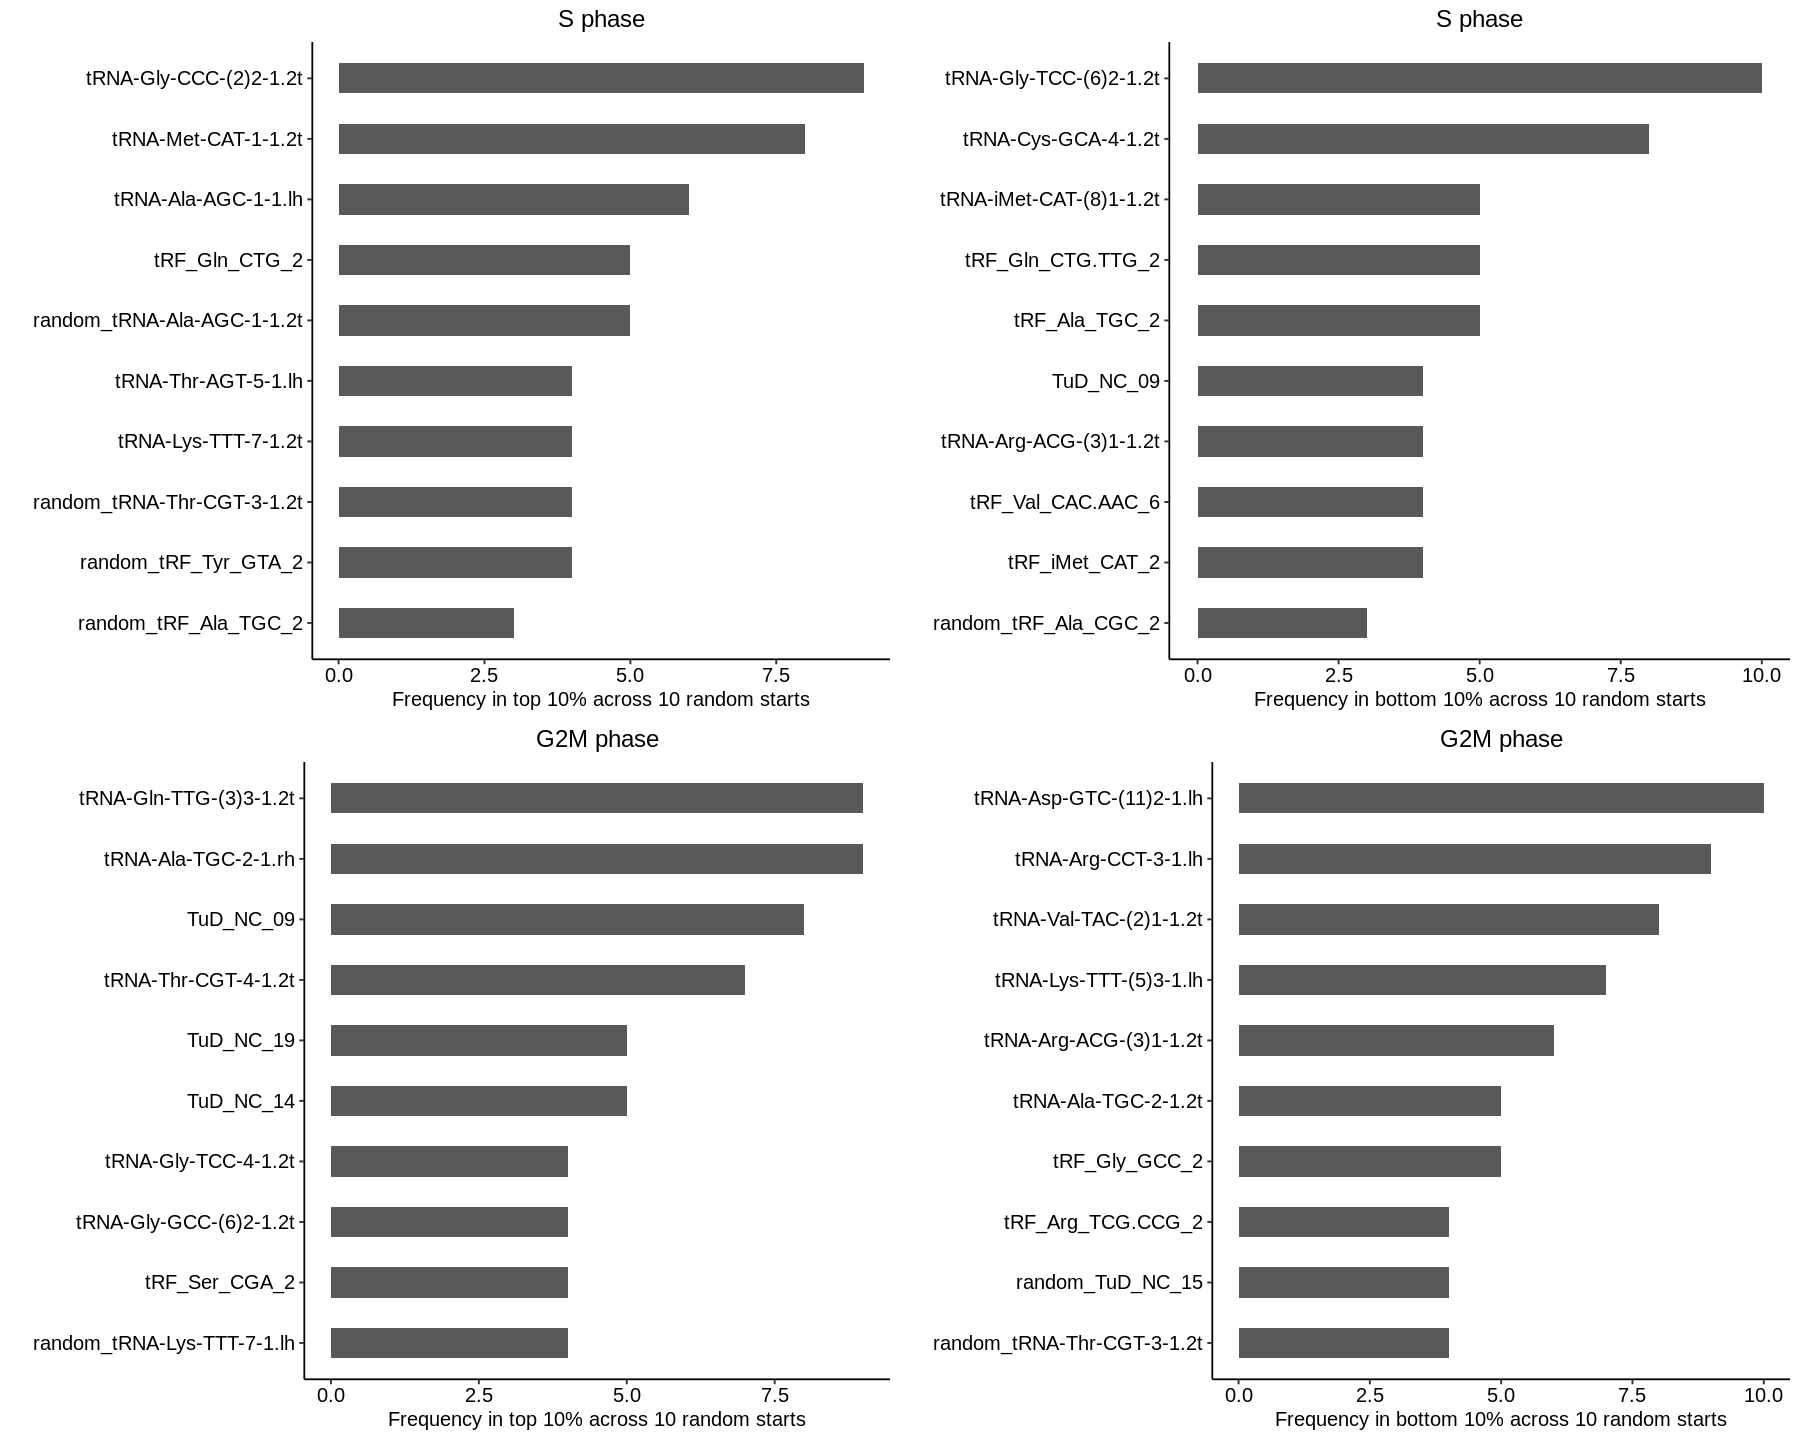

In [27]:
plot1 = ggplot(data = s_scores_top_guides, aes(x = reorder(s_scores_top_guides, Freq.in.top.10..across.10.random.starts), y = Freq.in.top.10..across.10.random.starts)) +
  geom_bar(stat = "identity", width = 0.5) + coord_flip() + ylab('Frequency in top 10% across 10 random starts') + xlab('') + ggtitle('S phase') + theme_pubr() + theme(plot.title = element_text(hjust = 0.5))

plot2 = ggplot(data = s_scores_bottom_guides, aes(x = reorder(s_scores_bottom_guides, Freq.in.bottom.10..across.10.random.starts), y = Freq.in.bottom.10..across.10.random.starts)) +
  geom_bar(stat = "identity", width = 0.5) + coord_flip() + ylab('Frequency in bottom 10% across 10 random starts') + xlab('') + ggtitle('S phase') + theme_pubr() + theme(plot.title = element_text(hjust = 0.5))

plot3 = ggplot(data = g2m_scores_top_guides, aes(x = reorder(g2m_scores_top_guides, Freq.in.top.10..across.10.random.starts), y = Freq.in.top.10..across.10.random.starts)) +
  geom_bar(stat = "identity", width = 0.5) + coord_flip() + ylab('Frequency in top 10% across 10 random starts') + xlab('') + ggtitle('G2M phase') + theme_pubr() + theme(plot.title = element_text(hjust = 0.5))

plot4 = ggplot(data = g2m_scores_bottom_guides, aes(x = reorder(g2m_scores_bottom_guides, Freq.in.bottom.10..across.10.random.starts), y = Freq.in.bottom.10..across.10.random.starts)) +
  geom_bar(stat = "identity", width = 0.5) + coord_flip() + ylab('Frequency in bottom 10% across 10 random starts') + xlab('') + ggtitle('G2M phase') + theme_pubr() + theme(plot.title = element_text(hjust = 0.5))

options(repr.plot.width = 15, repr.plot.height = 12)
ggarrange(plot1, plot2, plot3, plot4, ncol = 2, nrow = 2)

In [9]:
## there are no significant overlaps between the csv files except tRNA-Arg-ACG-(3)1-1.2t which is in bottom 10% of both S and G2M phase scores

## Graphs

In [10]:
## repeat graphs from heterogeneity analysis
s_scores_df_list_combined = read.csv('/home/ssobti/projects/mir_tud/output_data/cellcycle/tRF/s_scores_df_list_combined.csv')
g2m_scores_df_list_combined = read.csv('/home/ssobti/projects/mir_tud/output_data/cellcycle/tRF/g2m_scores_df_list_combined.csv')

increasing_s_scores_guides = s_scores_df_list_combined %>% group_by(random_start) %>% filter(score > quantile(score, 0.9)) %>% pull(guide) %>% as.character() %>% table() %>% as.data.frame %>% arrange(-Freq)
decreasing_s_scores_guides = s_scores_df_list_combined %>% group_by(random_start) %>% filter(score < quantile(score, 0.1)) %>% pull(guide) %>% as.character() %>% table() %>% as.data.frame %>% arrange(-Freq)
increasing_g2m_scores_guides = g2m_scores_df_list_combined %>% group_by(random_start) %>% filter(score > quantile(score, 0.9)) %>% pull(guide) %>% as.character() %>% table() %>% as.data.frame %>% arrange(-Freq)
decreasing_g2m_scores_guides = g2m_scores_df_list_combined %>% group_by(random_start) %>% filter(score < quantile(score, 0.1)) %>% pull(guide) %>% as.character() %>% table() %>% as.data.frame %>% arrange(-Freq)

combined_list = list(increasing_s_scores_guides, decreasing_s_scores_guides, increasing_g2m_scores_guides, decreasing_g2m_scores_guides)

library(tidyverse)

smooth_ecdfs = list()
rough_ecdfs = list()
select_guides_medians_scores = list()
select_random_guides_medians_scores = list()
select_guide_median_scores_plot = list()
select_random_guides_medians_scores_combined = list()

for (i in 1:length(combined_list)){
    colnames(combined_list[[i]])[1:2] = c('guide', 'Freq in top 10% across 10 random starts')
    combined_list[[i]]$guide = as.character(combined_list[[i]]$guide)
    combined_list[[i]]$type = ifelse(startsWith(as.character(combined_list[[i]]$guide), 'random_'), 'random', 'guide')
    dat = combined_list[[i]]
    dat$x = dat$`Freq in top 10% across 10 random starts`
    dat$group = dat$type
    


    # Split the data by group and calculate the smoothed cumulative density for each group
    dens = split(dat, dat$group) %>% 
    map_df(function(d) {
        dens = density(d$x, adjust=0.1, from=min(dat$x) - 0.05*diff(range(dat$x)), 
                    to=max(dat$x) + 0.05*diff(range(dat$x)))
        data.frame(x=dens$x, y=dens$y, cd=cumsum(dens$y)/sum(dens$y), group=d$group[1])
    })

    dens$group = factor(dens$group, levels = c('random', 'guide'))
    ## smooth ecdf
    smooth_ecdfs[[i]] = ggplot() +
    geom_line(data=dens, aes(x, cd, color = group)) + scale_color_hue(direction = -1) + xlab('Freq in top 10% across 10 random starts') + ylab('Cumulative density') +
    theme_classic()

    ## rough step ecdf
    rough_ecdfs[[i]] = ggplot(combined_list[[i]], aes(`Freq in top 10% across 10 random starts`, color = type)) + scale_color_hue(direction = -1) + stat_ecdf(geom = "step") + theme_classic()

    if (i <= 2){
        select_guides_medians_scores[[i]] = s_scores_df_list_combined %>% dplyr::filter(guide %in% combined_list[[i]]$guide[!startsWith(combined_list[[i]]$guide, 'random_')][1:4]) %>% group_by(guide) %>% summarize(median_score = median(score))
        select_random_guides_medians_scores[[i]] = s_scores_df_list_combined %>% dplyr::filter(guide %in% combined_list[[i]]$guide[startsWith(combined_list[[i]]$guide, 'random_')][1:4]) %>% group_by(guide) %>% summarize(median_score = median(score))
    }
    else {
        select_guides_medians_scores[[i]] = g2m_scores_df_list_combined %>% dplyr::filter(guide %in% combined_list[[i]]$guide[!startsWith(combined_list[[i]]$guide, 'random_')][1:4]) %>% group_by(guide) %>% summarize(median_score = median(score))
        select_random_guides_medians_scores[[i]] = g2m_scores_df_list_combined %>% dplyr::filter(guide %in% combined_list[[i]]$guide[startsWith(combined_list[[i]]$guide, 'random_')][1:4]) %>% group_by(guide) %>% summarize(median_score = median(score))
    }
    select_random_guides_medians_scores_combined[[i]] = bind_rows(select_guides_medians_scores[[i]] %>% mutate(group = "guide"), select_random_guides_medians_scores[[i]] %>% mutate(group = "random"))
    select_random_guides_medians_scores_combined_graphing = select_random_guides_medians_scores_combined[[i]]
    select_random_guides_medians_scores_combined_graphing$group = factor(select_random_guides_medians_scores_combined_graphing$group, levels = c('random', 'guide'))
    select_guide_median_scores_plot[[i]] = ggplot(select_random_guides_medians_scores_combined_graphing, aes(x = group, y = median_score, fill = group)) + 
    geom_boxplot() + theme_bw() + theme(axis.text.x = element_text(angle = 90, hjust = 1), plot.title = element_text(hjust = 0.5, margin = margin(0,0,12,0)), plot.margin = unit(c(0.8, 0.5, 0.5, 0.5), 'cm'), 
    axis.title.x = element_blank(), legend.position = 'none') + scale_fill_hue(direction = -1) + ylab('Median z-score of top guides') + coord_cartesian(clip = 'off') + ylim(-0.35, 0.35)

}

saveRDS(select_random_guides_medians_scores_combined, '/home/ssobti/projects/mir_tud/fig_output/data/fig3/tRF_select_random_guides_medians_scores_combined.rds')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ lubridate 1.9.3     ✔ stringr   1.5.1
✔ purrr     1.0.2     ✔ tibble    3.2.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [11]:
## ks test and t-test -- Anderson-Darling test also tried
ks_tests = list()
t_tests = list()
ad_tests = list()
for (i in 1:length(combined_list)){
    guides = combined_list[[i]]$guide
    freq = combined_list[[i]]$`Freq in top 10% across 10 random starts`
    ks_tests[[i]] = ks.test(freq[!startsWith(guides, 'random_')], freq[startsWith(guides, 'random_')], alternative = 'less')
    ks_tests[[i]] = ks_tests[[i]]$p.value
    ad_tests[[i]] = ad_test(freq[!startsWith(guides, 'random_')], freq[startsWith(guides, 'random_')])
    ad_tests[[i]] = as.numeric(ad_tests[[i]]['P-Value'])
    if (i %% 2 == 1){
        t_tests[[i]] = t.test(subset(select_random_guides_medians_scores_combined[[i]], group == 'guide')$median_score, subset(select_random_guides_medians_scores_combined[[i]], group == 'random')$median_score, alternative = 'greater')
        t_tests[[i]] = t_tests[[i]]$p.value
    } else {
        t_tests[[i]] = t.test(subset(select_random_guides_medians_scores_combined[[i]], group == 'guide')$median_score, subset(select_random_guides_medians_scores_combined[[i]], group == 'random')$median_score, alternative = 'less')
        t_tests[[i]] = t_tests[[i]]$p.value
    }
}
t_tests = unlist(t_tests)
ks_tests = unlist(ks_tests)
ad_tests = unlist(ad_tests)
t_tests = p.adjust(t_tests, method = 'fdr')
ks_tests = p.adjust(ks_tests, method = 'fdr')
ad_tests = p.adjust(ad_tests, method = 'fdr')

In [12]:
t_tests
ks_tests
ad_tests

[1] 0.050447949 0.041969889 0.003091772 0.003091772

[1] 1.292127e-01 5.798479e-02 5.137319e-02 2.223227e-05

[1] 0.1435 0.0440 0.0090 0.0010

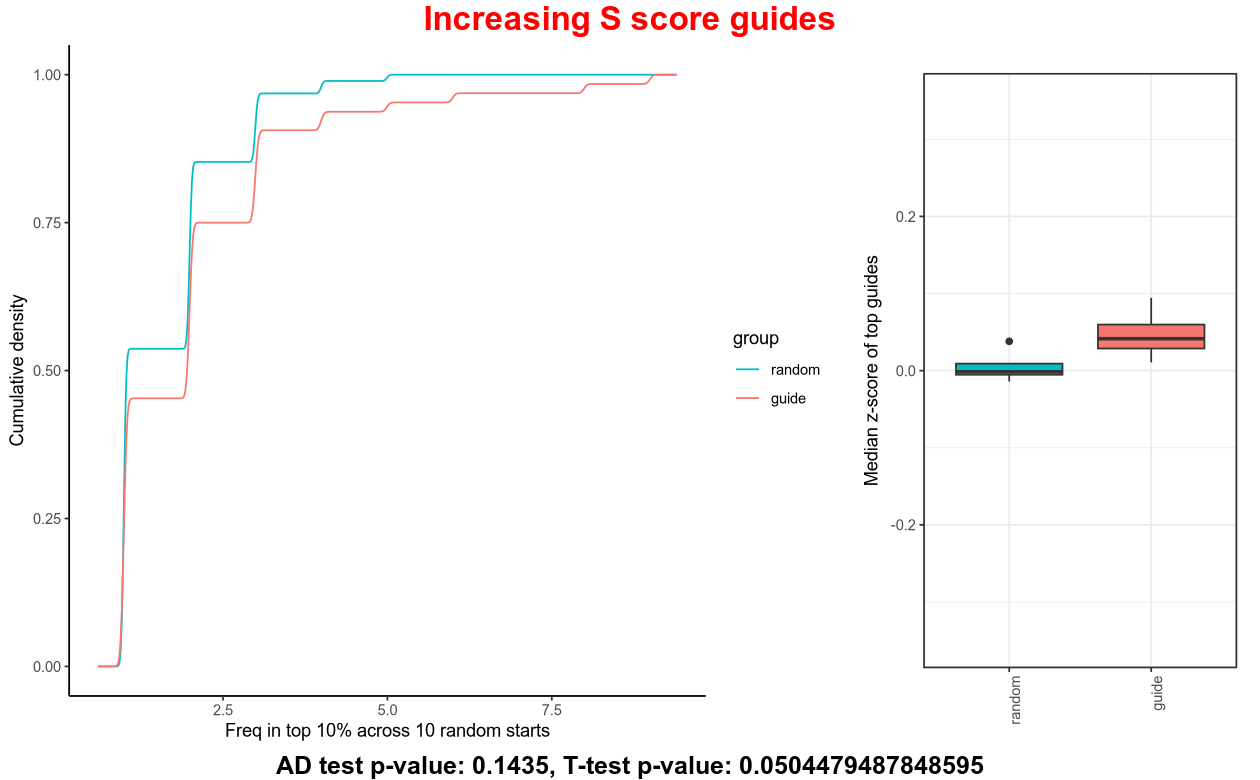

In [13]:
options(repr.plot.width = 10.5, repr.plot.height = 6.5)
figure = ggarrange(smooth_ecdfs[[1]], select_guide_median_scores_plot[[1]], ncol = 2, nrow = 1, widths = c(1, 0.5))
annotate_figure(figure, top = text_grob("Increasing S score guides", color = "red", face = "bold", size = 20), bottom = text_grob(paste0("AD test p-value: ", ad_tests[1], ", T-test p-value: ", t_tests[1]), color = "black", face = "bold", size = 15))
ggsave('/home/ssobti/projects/mir_tud/output_data/cellcycle/tRF/increasing_s_scores.pdf', width = 10.5, height = 6.5)

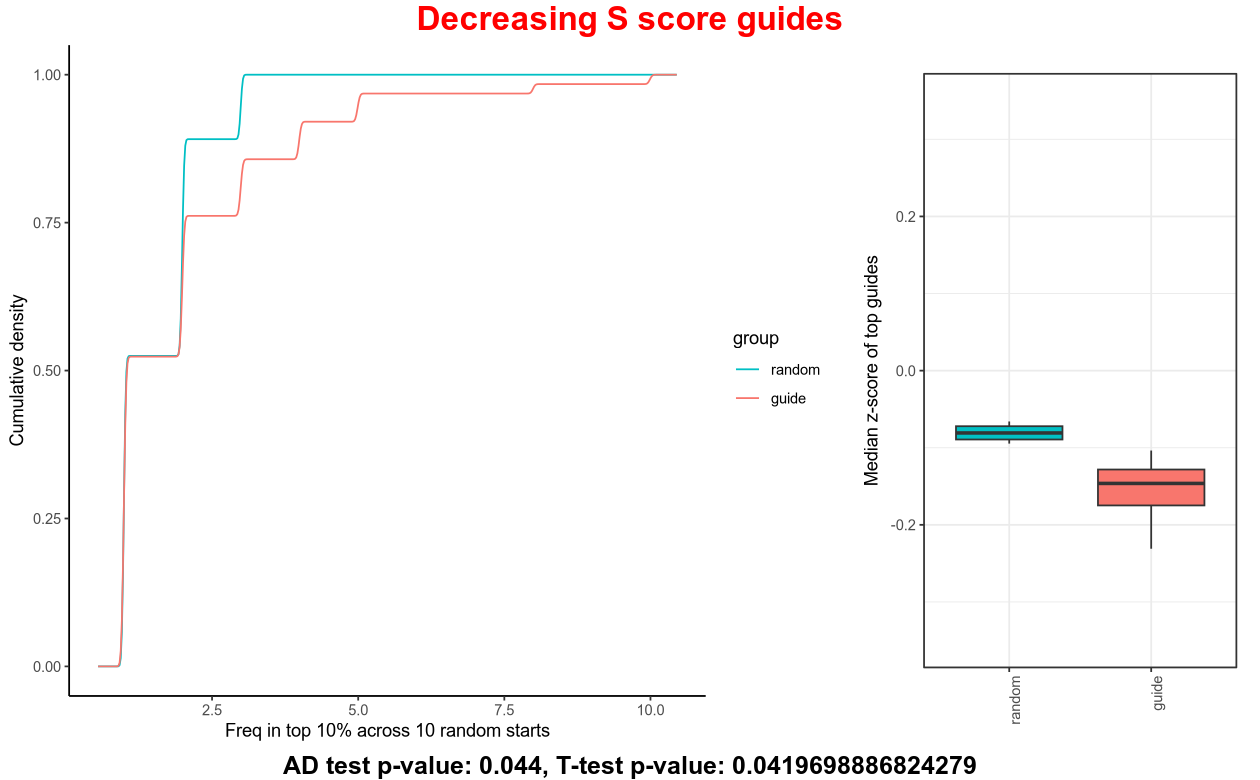

In [14]:
figure = ggarrange(smooth_ecdfs[[2]], select_guide_median_scores_plot[[2]], ncol = 2, nrow = 1, widths = c(1, 0.5))
annotate_figure(figure, top = text_grob("Decreasing S score guides", color = "red", face = "bold", size = 20), bottom = text_grob(paste0("AD test p-value: ", ad_tests[2], ", T-test p-value: ", t_tests[2]), color = "black", face = "bold", size = 15))
ggsave('/home/ssobti/projects/mir_tud/output_data/cellcycle/tRF/decreasing_s_scores.pdf', width = 10.5, height = 6.5)

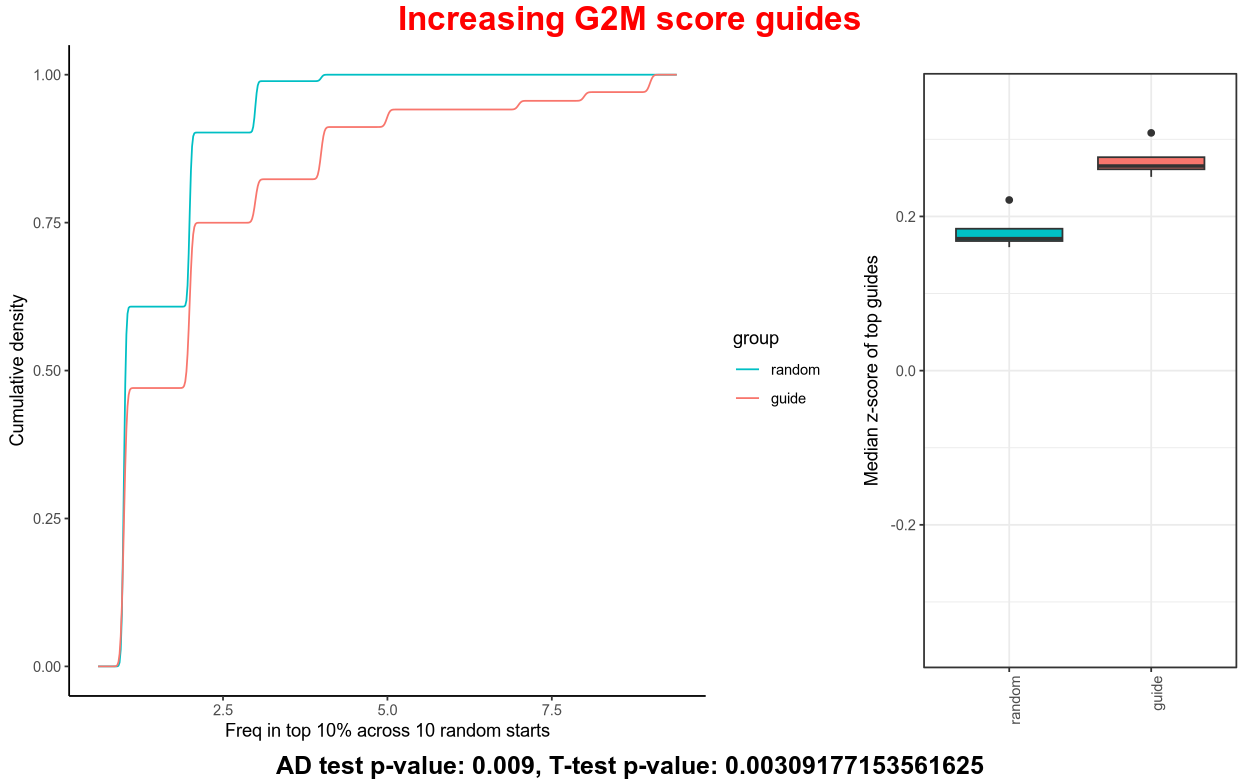

In [15]:
figure = ggarrange(smooth_ecdfs[[3]], select_guide_median_scores_plot[[3]], ncol = 2, nrow = 1, widths = c(1, 0.5))

annotate_figure(figure, top = text_grob("Increasing G2M score guides", color = "red", face = "bold", size = 20), bottom = text_grob(paste0("AD test p-value: ", ad_tests[3], ", T-test p-value: ", t_tests[3]), color = "black", face = "bold", size = 15))
ggsave('/home/ssobti/projects/mir_tud/output_data/cellcycle/tRF/increasing_g2m_scores.pdf', width = 10.5, height = 6.5)

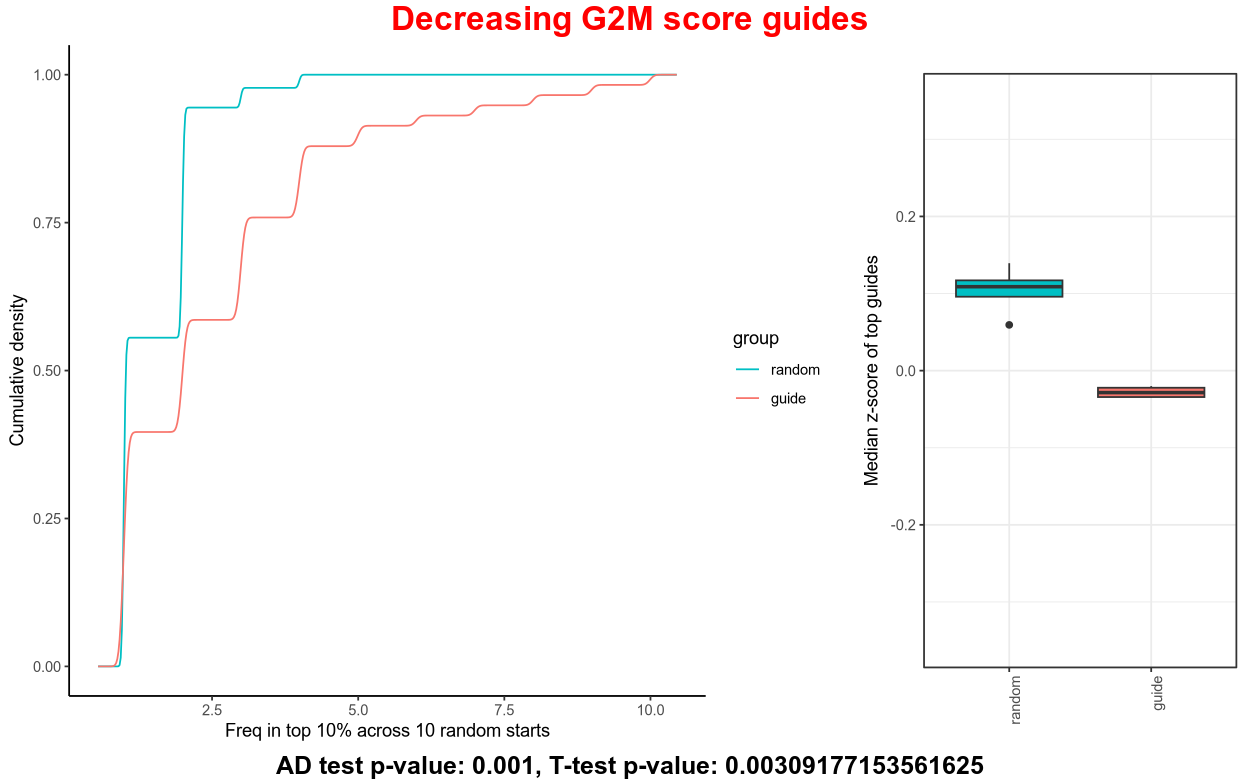

In [16]:
figure = ggarrange(smooth_ecdfs[[4]], select_guide_median_scores_plot[[4]], ncol = 2, nrow = 1, widths = c(1, 0.5))
annotate_figure(figure, top = text_grob("Decreasing G2M score guides", color = "red", face = "bold", size = 20), bottom = text_grob(paste0("AD test p-value: ", ad_tests[4], ", T-test p-value: ", t_tests[4]), color = "black", face = "bold", size = 15))
ggsave('/home/ssobti/projects/mir_tud/output_data/cellcycle/tRF/decreasing_g2m_scores.pdf', width = 10.5, height = 6.5)

Warning message:
“ggrepel: 279 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 276 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 264 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 253 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


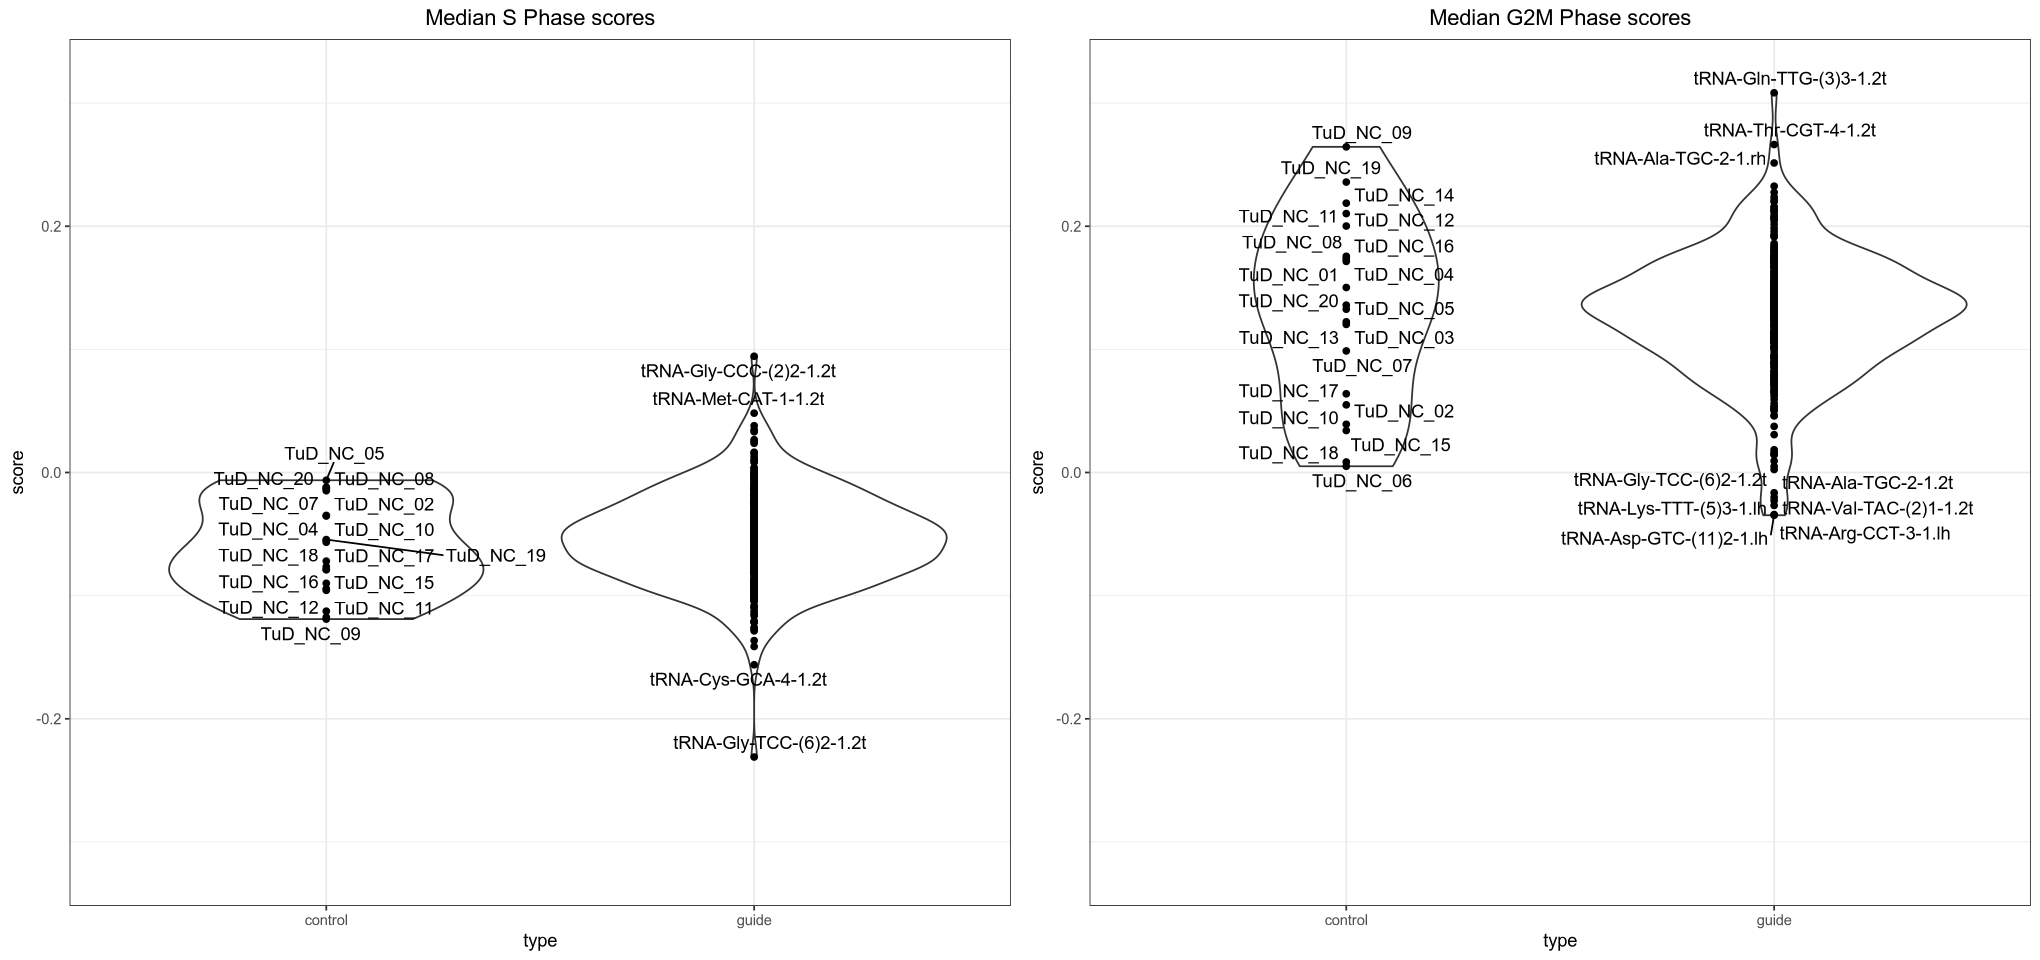

In [17]:
## get median s and g2m scores for each guide across 10 samplings
s_scores_by_seed = s_scores_df_list_combined %>% group_by(guide) %>% summarize(score = median(score)) %>% mutate(type = ifelse(startsWith(guide, 'TuD_NC'), 'control', 'guide'))
g2m_scores_by_seed = g2m_scores_df_list_combined %>% group_by(guide) %>% summarize(score = median(score)) %>% mutate(type = ifelse(startsWith(guide, 'TuD_NC'), 'control', 'guide'))
saveRDS(s_scores_by_seed, '/home/ssobti/projects/mir_tud/fig_output/data/fig3/tRF_s_scores_by_seed.rds')
saveRDS(g2m_scores_by_seed, '/home/ssobti/projects/mir_tud/fig_output/data/fig3/tRF_g2m_scores_by_seed.rds')

options(repr.plot.width = 17, repr.plot.height = 8)
s_phase = ggplot(s_scores_by_seed, aes(x=type, y=score)) + 
    geom_violin(trim=TRUE) + geom_point() + geom_text_repel(aes(label=guide)) + ggtitle('Median S Phase scores') + theme_bw() + theme(plot.title = element_text(hjust = 0.5)) + ylim(-0.32,0.32)


g2m_phase = ggplot(g2m_scores_by_seed, aes(x=type, y=score)) + 
    geom_violin(trim=TRUE) + geom_point() + geom_text_repel(aes(label=guide)) + ggtitle('Median G2M Phase scores') + theme_bw() + theme(plot.title = element_text(hjust = 0.5)) + ylim(-0.32,0.32)

ggarrange(s_phase, g2m_phase, ncol = 2)

ggsave('/home/ssobti/projects/mir_tud/output_data/cellcycle/tRF/tRF_cellcycle_median_scores_violin_across_10_cell_samplings_excluding_perturbations_below_30_cells.pdf', width = 17, height = 8)